In [1]:
from huggingface_hub import HfApi
from datasets import load_dataset

REPO = "buruzaemon/amazon_reviews_multi"
api = HfApi()
files = api.list_repo_files(REPO, repo_type="dataset")

def hf_url(path):
    return f"https://huggingface.co/datasets/{REPO}/resolve/main/{path}"

def pick_train_file(lang: str):
    
    candidates = [f for f in files if f.startswith(f"{lang}/") and "train" in f.lower()]
    if not candidates:
        raise ValueError(f"Aucun fichier train trouvé pour la langue: {lang}")

    
    for ext in [".parquet", ".json.gz", ".json"]:
        for f in candidates:
            if f.endswith(ext):
                return f
    return candidates[0]

def load_lang_train(lang: str):
    train_file = pick_train_file(lang)
    url = hf_url(train_file)
    if train_file.endswith(".parquet"):
        ds = load_dataset("parquet", data_files={"train": url}, split="train")
    else:
        ds = load_dataset("json", data_files={"train": url}, split="train")
    return ds

ds_en = load_lang_train("en")
ds_fr = load_lang_train("fr")


c:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

def to_minimal_df(ds, lang_code):
    df = ds.to_pandas()

   
    text_col = "review_body" if "review_body" in df.columns else df.columns[df.columns.str.contains("review", case=False)][0]
    stars_col = "stars" if "stars" in df.columns else "review_rating"

    cols_keep = [text_col, stars_col]
    for c in ["product_category", "language"]:
        if c in df.columns:
            cols_keep.append(c)

    df = df[cols_keep].copy()
    df = df.rename(columns={text_col: "review_body", stars_col: "stars"})

    df["language"] = lang_code  # on force EN/FR
    df["stars"] = df["stars"].astype(int)
    df = df.dropna(subset=["review_body", "stars"])
    return df

df_en = to_minimal_df(ds_en, "en")
df_fr = to_minimal_df(ds_fr, "fr")


def stratified_sample_by_stars(df, n=500, seed=42):
    df = df.copy()
    # on impose les 5 classes 1..5
    per_star = n // 5  # 100 si n=500
    # sécurité : vérifier qu’on a assez d’exemples par étoile
    counts = df["stars"].value_counts().to_dict()
    for s in [1,2,3,4,5]:
        if counts.get(s, 0) < per_star:
            raise ValueError(f"Pas assez d'exemples pour stars={s}: {counts.get(s,0)} disponibles, {per_star} requis")

    out = (df.groupby("stars", group_keys=False)
             .apply(lambda g: g.sample(n=per_star, random_state=seed)))
    # shuffle final
    out = out.sample(frac=1, random_state=seed).reset_index(drop=True)
    return out

df_en_500 = stratified_sample_by_stars(df_en, n=500, seed=42)
df_fr_500 = stratified_sample_by_stars(df_fr, n=500, seed=42)

df_1000 = pd.concat([df_en_500, df_fr_500], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)


C:\Users\tsats\AppData\Local\Temp\ipykernel_12060\4040363512.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=per_star, random_state=seed)))
C:\Users\tsats\AppData\Local\Temp\ipykernel_12060\4040363512.py:38: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=per_star, random_state=seed)))


In [3]:
print("Taille:", df_1000.shape)
print("\nLangues:")
print(df_1000["language"].value_counts())

print("\nStratification étoiles (global):")
print(df_1000["stars"].value_counts().sort_index())

print("\nStratification étoiles (par langue):")
print(pd.crosstab(df_1000["language"], df_1000["stars"]))


Taille: (1000, 4)

Langues:
language
fr    500
en    500
Name: count, dtype: int64

Stratification étoiles (global):
stars
1    200
2    200
3    200
4    200
5    200
Name: count, dtype: int64

Stratification étoiles (par langue):
stars       1    2    3    4    5
language                         
en        100  100  100  100  100
fr        100  100  100  100  100


In [4]:
df_1000.to_csv("amazon_reviews_multi_1000_fr_en_stratified.csv", index=False, encoding="utf-8")

In [5]:
def show_examples(df, lang, n=5, seed=42, max_len=300):
    ex = (df[df["language"] == lang]
          .sample(n=n, random_state=seed)
          .loc[:, ["stars", "review_body"]]
          .copy())
    ex["review_body"] = ex["review_body"].astype(str).str.replace(r"\s+", " ", regex=True).str.slice(0, max_len)
    print(f"\n===== EXEMPLES {lang.upper()} (n={n}) =====")
    for i, row in ex.reset_index(drop=True).iterrows():
        print(f"\n--- Exemple {i+1} | stars={row['stars']} ---\n{row['review_body']}")
        
show_examples(df_1000, "fr", n=5, seed=42)
show_examples(df_1000, "en", n=5, seed=42)



===== EXEMPLES FR (n=5) =====

--- Exemple 1 | stars=2 ---
La résine a un très bon effet Mais je suis déçue car il y a des résidus blanc dans le bison A qu'il a fallu "pêcher" avant que la résine ne se fige Pour le prix c'est un peu moyen

--- Exemple 2 | stars=2 ---
Utilisation pour mon portable

--- Exemple 3 | stars=4 ---
Je le rachète à chaque fois pour me laver les dreads. Mousse bien, ne laisse pas de résidus. Les cheveux sont bien nettoyés mais il faut BIEN les hydrater par la suite.

--- Exemple 4 | stars=1 ---
je ne pense pas avoir été suffisamment vigilant quant au délai de livraison annoncé !!! en plus le prix !!! Pour dire que rien ne justifiait le fait que je passe commande chez vous !!! Je ne réitérerai pas, c'est certain !

--- Exemple 5 | stars=4 ---
J'ai déjà commandé et ces têtes durent au moins aussi longtemps que les têtes d'origine

===== EXEMPLES EN (n=5) =====

--- Exemple 1 | stars=1 ---
Bought two based on the number of positive reviews, first one broke within

In [6]:
df_1000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_body       1000 non-null   object
 1   stars             1000 non-null   int64 
 2   product_category  1000 non-null   object
 3   language          1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [7]:
df_1000 = df_1000.rename(columns={"review_body":"text"})

## 1) Exploration rapide (EDA)
### 1.1 Distributions (langue, étoiles, catégories)

In [8]:
display(df_1000["language"].value_counts())
display(df_1000["stars"].value_counts().sort_index())
display(df_1000["product_category"].value_counts().head(10))

language
fr    500
en    500
Name: count, dtype: int64

stars
1    200
2    200
3    200
4    200
5    200
Name: count, dtype: int64

product_category
home                116
wireless             93
toy                  56
drugstore            53
home_improvement     50
other                47
apparel              45
electronics          43
pc                   41
beauty               41
Name: count, dtype: int64

### 1.2 Longueur des textes (diagnostic qualité)

In [9]:
df_1000["n_chars"] = df_1000["text"].astype(str).str.len()
df_1000["n_words"] = df_1000["text"].astype(str).str.split().apply(len)

df_1000[["n_chars","n_words"]].describe()

,n_chars,n_words
count,1000.000000,1000.000000
mean,165.946000,30.487000
std,165.445082,31.054407
min,20.000000,2.000000
25%,63.000000,11.000000
50%,121.000000,22.000000
75%,208.000000,38.000000
max,1751.000000,329.000000


In [10]:
# Exemples 
for lang in ["fr","en"]:
    print("\n====", lang, "====")
    display(df_1000[df_1000["language"]==lang][["stars","text"]].sample(3, random_state=0))



==== fr ====


,stars,text
165,5,Belle couleur...au toucher parfait. S adapte b...
528,1,le produit reçu ne correspond pas à ce que j'a...
597,1,"Bonjour, J'ai reçu mon colis avec d'autre prod..."



==== en ====


,stars,text
193,4,"Good product, brown was a little off on color"
489,4,The grater works okay but not great. The file ...
542,4,"This is a gorgeous band, but a little difficul..."


### 2) Création d’une étiquette de sentiment (baseline)

Basé sur les étoiles (simple et classique) :

- 1–2 → negative

- 3 → neutral

- 4–5 → positive

In [11]:
def stars_to_sentiment(stars):
    if stars <= 2:
        return "negative"
    if stars == 3:
        return "neutral"
    return "positive"

df_1000["sentiment"] = df_1000["stars"].apply(stars_to_sentiment)
df_1000["sentiment"].value_counts()

sentiment
positive    400
negative    400
neutral     200
Name: count, dtype: int64

### 3) Préparation des données

(Nettoyage + Tokenisation + Stopwords + Lemmatisation + POS)

#### 3.1 Nettoyage (léger + stable)

> On garde une version “model-friendly” (lower, suppression URLs) et une version “vader-friendly” (garde ponctuation/majuscules).

In [12]:
import re

URL_RE = re.compile(r"http\S+|www\.\S+")
MULTISPACE_RE = re.compile(r"\s+")

def clean_for_models(text):
    text = str(text)
    text = URL_RE.sub(" ", text)
    text = text.replace("\n", " ")
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text

def clean_for_vader(text):
    text = str(text)
    text = URL_RE.sub(" ", text)
    text = text.replace("\n", " ")
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text  # on garde majuscules / ponctuation

df_1000["text_clean"] = df_1000["text"].apply(clean_for_models)
df_1000["text_vader"] = df_1000["text"].apply(clean_for_vader)


#### 3.2 Tokenisation + Stopwords (FR+EN) + garde négations

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ressources NLTK (à faire une seule fois)
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

stop_fr = set(stopwords.words("french"))
stop_en = set(stopwords.words("english"))
stop_all = stop_fr | stop_en

NEGATIONS = {"ne","pas","jamais","rien","plus","aucun","sans","not","no","never","n't"}
stop_keep_neg = stop_all - NEGATIONS

def tokenize_and_filter(text):
    tokens = word_tokenize(text)
    out = []
    for t in tokens:
        t = t.strip()
        if not t:
            continue
        if len(t) <= 2 and t not in NEGATIONS:
            continue
        if t in stop_keep_neg:
            continue
        # enlève tokens pure ponctuation
        if re.fullmatch(r"\W+", t):
            continue
        out.append(t)
    return out

df_1000["tokens"] = df_1000["text_clean"].apply(tokenize_and_filter)
df_1000[["text_clean","tokens"]].head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tsats\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tsats\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tsats\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text_clean,tokens
0,Fonctionne parfaitement très efficace exelent ...,"[Fonctionne, parfaitement, très, efficace, exe..."
1,"J'ai reçu mon livre abîmé, il y a une grande c...","[J'ai, reçu, livre, abîmé, grande, coupure, pr..."
2,J'utilise ces boîtes pour faire du diamond.pai...,"[J'utilise, boîtes, faire, diamond.painting, j..."
3,Poster beau mes pars contre délai trop long vo...,"[Poster, beau, pars, contre, délai, trop, long..."
4,Very bland tasting and over-priced whole food ...,"[Very, bland, tasting, over-priced, whole, foo..."


#### 3.3 Lemmatisation + POS avec spaCy

In [14]:
import sys
!{sys.executable} -m spacy download fr_core_news_sm
!{sys.executable} -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     - -------------------------------------- 0.5/16.3 MB 4.1 MB/s eta 0:00:04
     ---- ----------------------------------- 1.8/16.3 MB 6.3 MB/s eta 0:00:03
     ------- -------------------------------- 3.1/16.3 MB 6.1 MB/s eta 0:00:03
     ---------- ----------------------------- 4.2/16.3 MB 5.9 MB/s eta 0:00:03
     ------------ --------------------------- 5.0/16.3 MB 5.6 MB/s eta 0:00:03
     ------------- -------------------------- 5.5/16.3 MB 4.8 MB/s eta 0:00:03
     -------------- ------------------------- 5.8/16.3 MB 4.4 MB/s eta 0:00:03
     -------------- ------------------------- 6.0/16.3 MB 4.0 MB/s eta 0:00:03
     -------------- ------------------------- 6.0/16.3 MB 4.0 MB/s eta 0:00:03
     --------------- ------------------------ 6.3/16.3 MB 3.2 MB/s eta 0:00:04
     --------------- ------------------------ 6.3/16.3 MB 3.2 MB/s eta 0:00:04
     ---------------- ----------------------- 6.8/16.3 MB 2

In [15]:
import spacy

nlp_fr = spacy.load("fr_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

def spacy_lemmas_pos(text, lang):
    nlp = nlp_fr if lang=="fr" else nlp_en
    doc = nlp(text)
    lemmas = []
    pos = []
    for tok in doc:
        if tok.is_space or tok.is_punct:
            continue
        lemmas.append(tok.lemma_.lower())
        pos.append(tok.pos_)
    return lemmas, pos

df_1000[["lemmas","pos"]] = df_1000.apply(lambda r: pd.Series(spacy_lemmas_pos(r["text"], r["language"])), axis=1)
df_1000[["text","lemmas","pos"]].head()


,text,lemmas,pos
0,Fonctionne parfaitement très efficace exelent ...,"[fonctionne, parfaitement, très, efficace, exe...","[NOUN, ADV, ADV, ADJ, ADV, NOUN, NOUN, NOUN]"
1,"J'ai reçu mon livre abîmé, il y a une grande c...","[je, avoir, recevoir, mon, livre, abîmé, il, y...","[PRON, AUX, VERB, DET, NOUN, ADJ, PRON, PRON, ..."
2,J'utilise ces boîtes pour faire du diamond.pai...,"[je, utiliser, ce, boîte, pour, faire, de, dia...","[PRON, VERB, DET, NOUN, ADP, VERB, DET, NOUN, ..."
3,Poster beau mes pars contre délai trop long vo...,"[poster, beau, mon, par, contre, délai, trop, ...","[VERB, NOUN, DET, NOUN, ADP, NOUN, ADV, ADJ, V..."
4,Very bland tasting and over-priced whole food ...,"[very, bland, tasting, and, over, price, whole...","[ADV, ADJ, ADJ, CCONJ, ADV, VERB, ADJ, NOUN, N..."


## 4) Analyse lexicon-based (polarité) + score

- EN : VADER

- FR : “VADER-FR” si dispo, sinon lexique FR (pédagogique)

In [16]:
# Vader Anglais
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

In [17]:
import sys
!{sys.executable} -m pip install -U vaderSentiment-fr

In [18]:
# Vader Français
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer

vader_fr = SentimentIntensityAnalyzer()
vader_fr.polarity_scores("Une phrase pas cool   à analyser")

c:\Python313\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


{'neg': 0.171, 'neu': 0.829, 'pos': 0.0, 'compound': -0.1139}

In [19]:
def label_from_score(score, pos_th=0.05, neg_th=-0.05):
    if score >= pos_th:
        return "positive"
    if score <= neg_th:
        return "negative"
    return "neutral"

In [20]:
def compute_lex(row):
    if row["language"] == "en":
        comp = vader.polarity_scores(row["text_vader"])["compound"]
        return comp, label_from_score(comp)
    else:
        comp = vader_fr.polarity_scores(row["text_vader"])["compound"]
        return comp, label_from_score(comp)

df_1000[["lex_score","lex_pred"]] = df_1000.apply(lambda r: pd.Series(compute_lex(r)), axis=1)


In [21]:
df_1000[["language","stars","sentiment","lex_score","lex_pred","text"]].head(10)

,language,stars,sentiment,lex_score,lex_pred,text
0,fr,5,positive,0.7960,positive,Fonctionne parfaitement très efficace exelent ...
1,fr,2,negative,-0.4215,negative,"J'ai reçu mon livre abîmé, il y a une grande c..."
2,fr,4,positive,0.2716,positive,J'utilise ces boîtes pour faire du diamond.pai...
3,fr,2,negative,0.1779,positive,Poster beau mes pars contre délai trop long vo...
4,en,1,negative,0.0000,neutral,Very bland tasting and over-priced whole food ...
5,fr,2,negative,0.7342,positive,"Pas prévenu de la livraison, heureusement le c..."
6,fr,5,positive,0.2714,positive,J’ai du Fibaro partout dans la maison et rien ...
7,fr,1,negative,-0.2023,negative,Pour baigner les enfants c'est pratique. Le pr...
8,fr,2,negative,0.0000,neutral,Ne valent pas les chiffons fournis lorsque vou...
9,en,2,negative,-0.4215,negative,Too small. Broke within a month.


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

print("=== GLOBAL ===")
print(classification_report(df_1000["sentiment"], df_1000["lex_pred"], digits=3))
print(confusion_matrix(df_1000["sentiment"], df_1000["lex_pred"]))

=== GLOBAL ===
              precision    recall  f1-score   support

    negative      0.708     0.455     0.554       400
     neutral      0.160     0.115     0.134       200
    positive      0.573     0.858     0.687       400

    accuracy                          0.548      1000
   macro avg      0.480     0.476     0.458      1000
weighted avg      0.544     0.548     0.523      1000

[[182  85 133]
 [ 54  23 123]
 [ 21  36 343]]


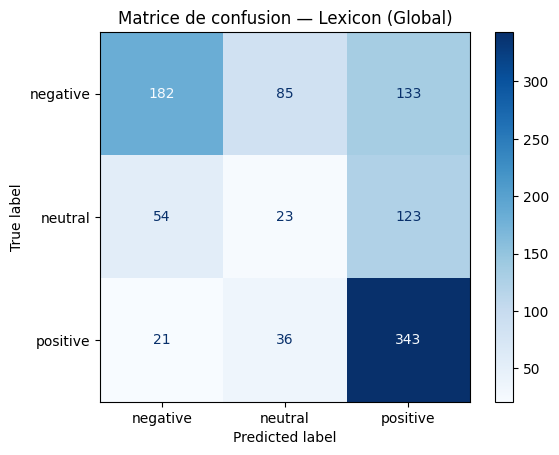

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["negative", "neutral", "positive"]

cm_disp = ConfusionMatrixDisplay.from_predictions(
    y_true=df_1000["sentiment"],
    y_pred=df_1000["lex_pred"],
    labels=labels,
    normalize=None,   # mets "true" pour des % par ligne
    cmap="Blues",
    values_format="d"
)

plt.title("Matrice de confusion — Lexicon (Global)")
plt.show()


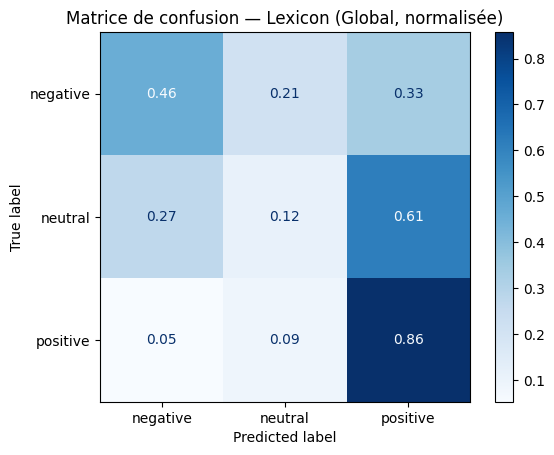

In [24]:
cm_disp = ConfusionMatrixDisplay.from_predictions(
    df_1000["sentiment"], df_1000["lex_pred"],
    labels=labels,
    normalize="true",
    cmap="Blues",
    values_format=".2f"
)
plt.title("Matrice de confusion — Lexicon (Global, normalisée)")
plt.show()

In [25]:
for lang in ["fr","en"]:
    sub = df_1000[df_1000["language"]==lang]
    print(f"\n=== {lang.upper()} ===")
    print(classification_report(sub["sentiment"], sub["lex_pred"], digits=3))
    print(confusion_matrix(sub["sentiment"], sub["lex_pred"]))



=== FR ===
              precision    recall  f1-score   support

    negative      0.713     0.460     0.559       200
     neutral      0.209     0.140     0.168       100
    positive      0.546     0.830     0.659       200

    accuracy                          0.544       500
   macro avg      0.489     0.477     0.462       500
weighted avg      0.545     0.544     0.521       500

[[ 92  34  74]
 [ 22  14  64]
 [ 15  19 166]]

=== EN ===
              precision    recall  f1-score   support

    negative      0.703     0.450     0.549       200
     neutral      0.117     0.090     0.102       100
    positive      0.600     0.885     0.715       200

    accuracy                          0.552       500
   macro avg      0.473     0.475     0.455       500
weighted avg      0.545     0.552     0.526       500

[[ 90  51  59]
 [ 32   9  59]
 [  6  17 177]]


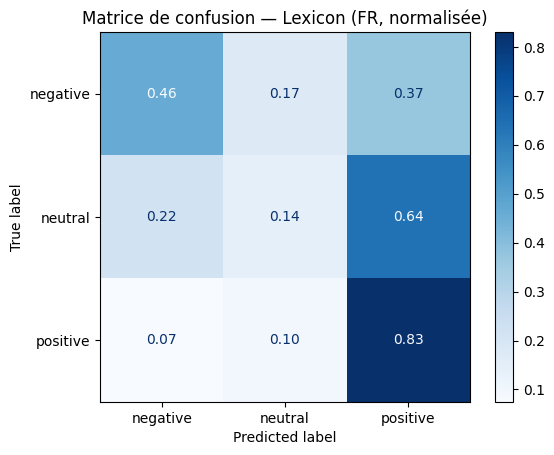

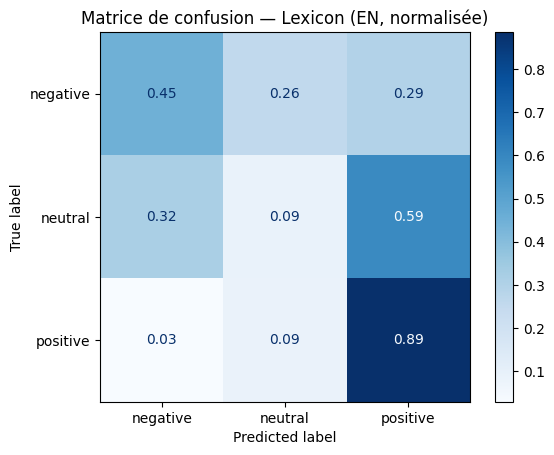

In [26]:
labels = ["negative", "neutral", "positive"]

for lang in ["fr", "en"]:
    sub = df_1000[df_1000["language"] == lang]
    
    ConfusionMatrixDisplay.from_predictions(
        sub["sentiment"], sub["lex_pred"],
        labels=labels,
        normalize="true",
        cmap="Blues",
        values_format=".2f"
    )
    plt.title(f"Matrice de confusion — Lexicon ({lang.upper()}, normalisée)")
    plt.show()


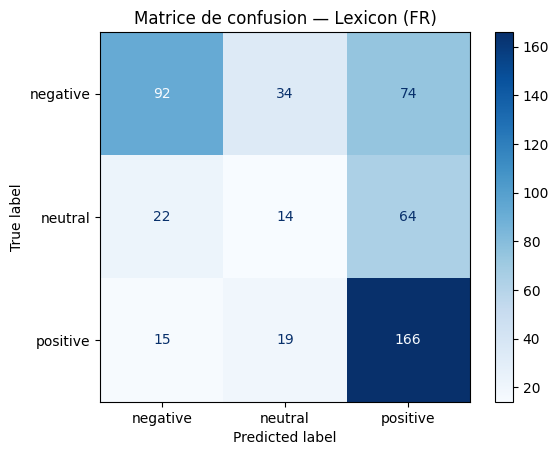

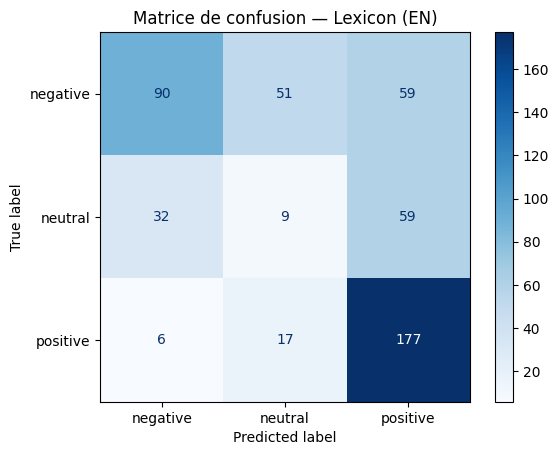

In [27]:
for lang in ["fr", "en"]:
    sub = df_1000[df_1000["language"] == lang]
    
    ConfusionMatrixDisplay.from_predictions(
        sub["sentiment"], sub["lex_pred"],
        labels=labels,
        normalize=None,
        cmap="Blues",
        values_format="d"
    )
    plt.title(f"Matrice de confusion — Lexicon ({lang.upper()})")
    plt.show()


### 5.2 Analyse des erreurs (exemples concrets)

In [28]:
errors = df_1000[df_1000["sentiment"] != df_1000["lex_pred"]]
errors.sample(10, random_state=0)[["language","stars","sentiment","lex_pred","lex_score","text"]]

,language,stars,sentiment,lex_pred,lex_score,text
272,fr,3,neutral,positive,0.0772,"La voix est exceptionnelle, le répertoire faib..."
123,en,3,neutral,positive,0.2382,Good scent but doesn't last long.
642,en,1,negative,positive,0.8767,The idea of the phone wallet is great! We like...
679,en,1,negative,positive,0.8121,From the online advertisement and photos I was...
516,en,1,negative,neutral,0.0000,I never received the package!
306,en,2,negative,neutral,0.0000,Box on the item was ripped
27,fr,5,positive,negative,-0.2263,"Roman court, la suite de la série des jeux. Ra..."
859,fr,3,neutral,negative,-0.5574,mauvaise qualité je trouve
870,fr,3,neutral,positive,0.6705,Bon produit mais j ai l impression qu il sèche...
163,fr,1,negative,neutral,0.0000,"Trop épais , il faudrait changer de pointure d..."


In [29]:
pd.set_option("display.max_colwidth", None)   # pas de troncature
pd.set_option("display.max_rows", 200)        # optionnel
pd.set_option("display.max_columns", None)    # optionnel

In [49]:
import pandas as pd
df = df_1000

df = df[["text", "sentiment", "language"]]
df.head()

,text,sentiment,language
0,Fonctionne parfaitement très efficace exelent rapport qualité prix,positive,fr
1,"J'ai reçu mon livre abîmé, il y a une grande coupure sur la première de couverture, dommage pour un livre ""neuf""",negative,fr
2,J'utilise ces boîtes pour faire du diamond.painting et j'en suis très satisfait,positive,fr
3,Poster beau mes pars contre délai trop long voilà pk mes 2etoiles,negative,fr
4,Very bland tasting and over-priced whole food brand.,negative,en


In [50]:
df["text"] = df["text"].str.lower()
df = df.dropna(subset=["text", "sentiment"])

C:\Users\tsats\AppData\Local\Temp\ipykernel_12060\3544353644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = df["text"].str.lower()


separation des donnees pour l'entrainement du modèle

In [51]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


NAIVES BAYES + TF

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

tf_nb = Pipeline([
    ("vectorizer", CountVectorizer(
        stop_words="english",  # OK même avec FR/EN mélangé
        max_features=10000
    )),
    ("classifier", MultinomialNB())
])

tf_nb.fit(X_train, y_train)

y_pred_tf = tf_nb.predict(X_test)

print("Accuracy TF + NB:", accuracy_score(y_test, y_pred_tf))
print(classification_report(y_test, y_pred_tf))

Accuracy TF + NB: 0.575
              precision    recall  f1-score   support

    negative       0.61      0.70      0.65        80
     neutral       0.15      0.07      0.10        40
    positive       0.64      0.70      0.67        80

    accuracy                           0.57       200
   macro avg       0.47      0.49      0.47       200
weighted avg       0.53      0.57      0.55       200



NAIVES BAYES + TF-IDF

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_nb = Pipeline([
    ("vectorizer", TfidfVectorizer(
        stop_words="english",
        max_features=15000,
        ngram_range=(1, 2)  # mots + bigrammes
    )),
    ("classifier", MultinomialNB())
])

tfidf_nb.fit(X_train, y_train)

y_pred_tfidf = tfidf_nb.predict(X_test)

print("Accuracy TF-IDF + NB:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

Accuracy TF-IDF + NB: 0.595
              precision    recall  f1-score   support

    negative       0.57      0.80      0.67        80
     neutral       0.00      0.00      0.00        40
    positive       0.62      0.69      0.65        80

    accuracy                           0.59       200
   macro avg       0.40      0.50      0.44       200
weighted avg       0.48      0.59      0.53       200



c:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


COMPARAISON TF vs TF-IDF

In [54]:
results = pd.DataFrame({
    "Model": ["TF + Naive Bayes", "TF-IDF + Naive Bayes"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_tf),
        accuracy_score(y_test, y_pred_tfidf)
    ]
})

results

,Model,Accuracy
0,TF + Naive Bayes,0.575
1,TF-IDF + Naive Bayes,0.595


RANDOM FOREST 

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [56]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)


In [57]:
rf.fit(X_train_tfidf, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [58]:
y_pred = rf.predict(X_test_tfidf)


In [59]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.565
              precision    recall  f1-score   support

    negative       0.55      0.64      0.59        80
     neutral       1.00      0.03      0.05        40
    positive       0.58      0.76      0.66        80

    accuracy                           0.56       200
   macro avg       0.71      0.47      0.43       200
weighted avg       0.65      0.56      0.51       200



EXEMPLES DE PREDICTION

TF 

In [60]:
import pandas as pd

examples_nb_tf = pd.DataFrame({
    "Text": X_test.iloc[:5].values,
    "True stars": y_test.iloc[:5].values,
    "Predicted stars (NB + TF)": y_pred_tf[:5]
})

examples_nb_tf


,Text,True stars,Predicted stars (NB + TF)
0,"as others have stated, i'm finding way too many of these wipes to be dry. when half your product doesn't meet expectations, you don't get a very good review.",negative,negative
1,la qualité est pas bonne du tout cette manette c’est surtout pour de la collection et encore,negative,negative
2,parfaitement conforme à la description câble de qualité utilisé dans mon véhicule pour brancher le téléphone et une clé usb en même temps,positive,positive
3,it was easy to assemble but comes apart easy when you move it. if child or grandchild is tall for their age it is a little short for the age they have as appropriate.,neutral,positive
4,"did not work for samsung galaxy s7, but did work for iphone se",negative,negative


TF-IDF

In [61]:
examples_nb_tfidf = pd.DataFrame({
    "Text": X_test.iloc[:5].values,
    "True stars": y_test.iloc[:5].values,
    "Predicted stars (NB + TF-IDF)": y_pred_tfidf[:5]
})

examples_nb_tfidf


,Text,True stars,Predicted stars (NB + TF-IDF)
0,"as others have stated, i'm finding way too many of these wipes to be dry. when half your product doesn't meet expectations, you don't get a very good review.",negative,negative
1,la qualité est pas bonne du tout cette manette c’est surtout pour de la collection et encore,negative,negative
2,parfaitement conforme à la description câble de qualité utilisé dans mon véhicule pour brancher le téléphone et une clé usb en même temps,positive,positive
3,it was easy to assemble but comes apart easy when you move it. if child or grandchild is tall for their age it is a little short for the age they have as appropriate.,neutral,positive
4,"did not work for samsung galaxy s7, but did work for iphone se",negative,negative


RANDOM FOREST

In [62]:
examples_rf = pd.DataFrame({
    "Text": X_test.iloc[:5].values,
    "True stars": y_test.iloc[:5].values,
    "Predicted stars (RF + TF-IDF)": y_pred[:5]
})

examples_rf


,Text,True stars,Predicted stars (RF + TF-IDF)
0,"as others have stated, i'm finding way too many of these wipes to be dry. when half your product doesn't meet expectations, you don't get a very good review.",negative,negative
1,la qualité est pas bonne du tout cette manette c’est surtout pour de la collection et encore,negative,negative
2,parfaitement conforme à la description câble de qualité utilisé dans mon véhicule pour brancher le téléphone et une clé usb en même temps,positive,positive
3,it was easy to assemble but comes apart easy when you move it. if child or grandchild is tall for their age it is a little short for the age they have as appropriate.,neutral,positive
4,"did not work for samsung galaxy s7, but did work for iphone se",negative,negative


COMPARAISON DES DIFFERENTES PREDICTIONS

In [63]:
comparison = pd.DataFrame({
    "Text": X_test.iloc[:5].values,
    "True stars": y_test.iloc[:5].values,
    "NB + TF": y_pred_tf[:5],
    "NB + TF-IDF": y_pred_tfidf[:5],
    "RF + TF-IDF": y_pred[:5]
})

comparison


,Text,True stars,NB + TF,NB + TF-IDF,RF + TF-IDF
0,"as others have stated, i'm finding way too many of these wipes to be dry. when half your product doesn't meet expectations, you don't get a very good review.",negative,negative,negative,negative
1,la qualité est pas bonne du tout cette manette c’est surtout pour de la collection et encore,negative,negative,negative,negative
2,parfaitement conforme à la description câble de qualité utilisé dans mon véhicule pour brancher le téléphone et une clé usb en même temps,positive,positive,positive,positive
3,it was easy to assemble but comes apart easy when you move it. if child or grandchild is tall for their age it is a little short for the age they have as appropriate.,neutral,positive,positive,positive
4,"did not work for samsung galaxy s7, but did work for iphone se",negative,negative,negative,negative


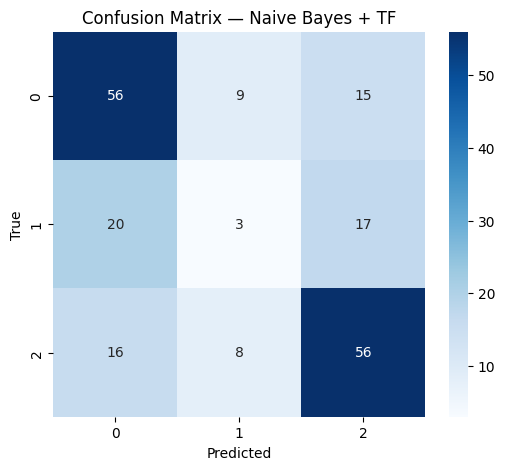

In [70]:
# Prédictions déjà calculées
# y_pred_nb_tf
import seaborn as sns

cm_nb_tf = confusion_matrix(y_test, y_pred_tf)

plt.figure(figsize=(6,5))
sns.heatmap(cm_nb_tf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Naive Bayes + TF")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


FEATURES LES PLUS IMPORTANTES NAIVES BAYES

In [64]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# 1) Pipeline
tfidf_nb = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=30000, ngram_range=(1,2))),
    ("nb", MultinomialNB())
])

# 2) FIT (IMPORTANT)
tfidf_nb.fit(X_train, y_train)

# 3) Récupérer objets internes FITTÉS
vectorizer = tfidf_nb.named_steps["tfidf"]
nb_model = tfidf_nb.named_steps["nb"]

feature_names = vectorizer.get_feature_names_out()
log_probs = nb_model.feature_log_prob_   # shape: (n_classes, n_features)

# 4) Mapper index de classe -> label réel (ex: stars 1..5)
class_labels = nb_model.classes_  # ex: array([1,2,3,4,5])

def top_features_for_label(label, top_n=15):
    class_idx = np.where(class_labels == label)[0][0]
    top_ids = np.argsort(log_probs[class_idx])[::-1][:top_n]
    return feature_names[top_ids]

# 5) Afficher top mots par classe
for label in class_labels:
    print(f"\nTop words for class {label}:")
    print(top_features_for_label(label, top_n=15))



Top words for class negative:
['the' 'le' 'it' 'pas' 'de' 'est' 'and' 'la' 'not' 'je' 'to' 'ne' 'en'
 'les' 'ai']

Top words for class neutral:
['the' 'to' 'le' 'est' 'it' 'de' 'mais' 'and' 'pas' 'un' 'not' 'et' 'la'
 'peu' 'for']

Top words for class positive:
['the' 'it' 'de' 'et' 'and' 'la' 'to' 'le' 'très' 'pour' 'is' 'for'
 'great' 'this' 'bien']


In [65]:
rows = []
for label in class_labels:
    class_idx = np.where(class_labels == label)[0][0]
    top_ids = np.argsort(log_probs[class_idx])[::-1][:10]
    for idx in top_ids:
        rows.append({
            "Class": label,
            "Word": feature_names[idx],
            "LogProb": float(log_probs[class_idx, idx])
        })

df_top_nb = pd.DataFrame(rows)
df_top_nb


,Class,Word,LogProb
0,negative,the,-7.587781
1,negative,le,-7.853929
2,negative,it,-7.907015
3,negative,pas,-7.950500
4,negative,de,-8.009718
5,negative,est,-8.074280
6,negative,and,-8.079250
7,negative,la,-8.095231
8,negative,not,-8.149743
9,negative,je,-8.229349


FEATURES LES PLUS IMPORTANT RANDOM FOREST

In [66]:
importances = rf.feature_importances_

top_idx = np.argsort(importances)[::-1][:30]

top_rf_features = pd.DataFrame({
    "Word": feature_names[top_idx],
    "Importance": importances[top_idx]
})

top_rf_features


,Word,Importance
0,installing ended,0.016643
1,expect the,0.014419
2,look at,0.012216
3,courage,0.011462
4,dosage,0.011121
5,knew,0.009424
6,laptop even,0.008905
7,does an,0.008807
8,is small,0.008806
9,malfunction warning,0.008477


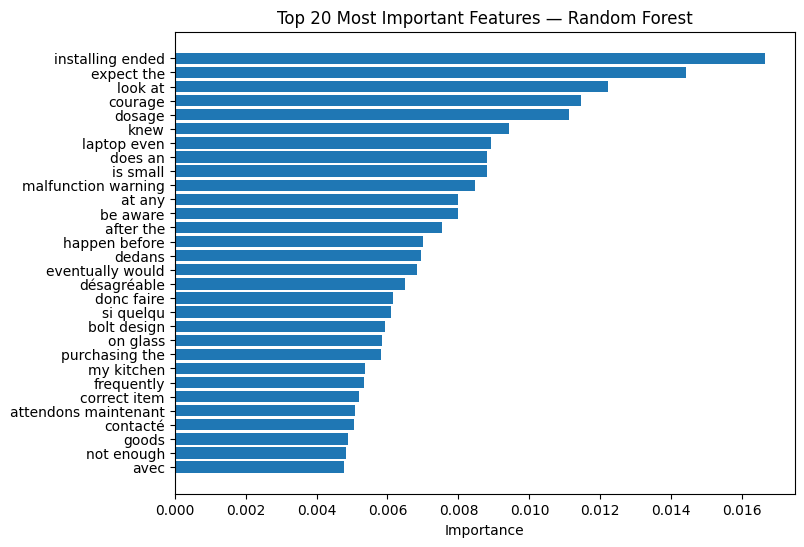

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.barh(top_rf_features["Word"][::-1],
         top_rf_features["Importance"][::-1])
plt.title("Top 20 Most Important Features — Random Forest")
plt.xlabel("Importance")
plt.show()
